# App Analysis

In [1]:
from __future__ import annotations

import json
import os
import pathlib

import seaborn
import polars
import matplotlib
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

Bad value in file 'matplotlibrc', line 14 ('hatch.color: #000000'): Key hatch.color: '' does not look like a color arg


In [2]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            execution_info = task_info.pop('execution')
            if execution_info is None:
                execution_info = {}
            exception_info = task_info.pop('exception')
            if exception_info is None:
                exception_info = {}
            task_info = {**task_info, **execution_info, **exception_info}
            tasks.append(task_info)

    return polars.DataFrame(tasks)

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.jsonl'):
        app, method, timestamp = str(tasks_path.relative_to(directory).parent).split('/')

        app = {
            'cholesky': 'Cholesky',
            'fedlearn': 'Fed. Learning',
            'moldesign': 'Molecular Design',
        }[app]
        method = {
            'baseline': 'Baseline',
            'proxystore': 'ProxyStore',
        }[method]
        
        tasks = load_tasks(tasks_path)
        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()        
        runtime = end_time - start_time

        run_info = {
            'app': app,
            'method': method,
            'timestamp': timestamp,
            'runtime': runtime,
        }
        runs.append(run_info)

    return polars.DataFrame(runs)

In [3]:
data = load_data(pathlib.Path('runs/apps/'))
data

app,method,timestamp,runtime
str,str,str,f64
"""Cholesky""","""Baseline""","""2024-08-07-18-13-49""",118.522465
"""Cholesky""","""Baseline""","""2024-08-07-18-17-38""",116.623833
"""Cholesky""","""Baseline""","""2024-08-07-18-10-03""",115.072168
"""Cholesky""","""ProxyStore""","""2024-08-07-18-12-22""",62.647036
"""Cholesky""","""ProxyStore""","""2024-08-07-18-16-11""",63.36638
"""Cholesky""","""ProxyStore""","""2024-08-07-18-19-59""",64.432619
"""Fed. Learning""","""Baseline""","""2024-08-07-19-12-28""",225.65101
"""Fed. Learning""","""Baseline""","""2024-08-07-19-04-53""",227.908576
"""Fed. Learning""","""Baseline""","""2024-08-07-18-56-54""",225.952395


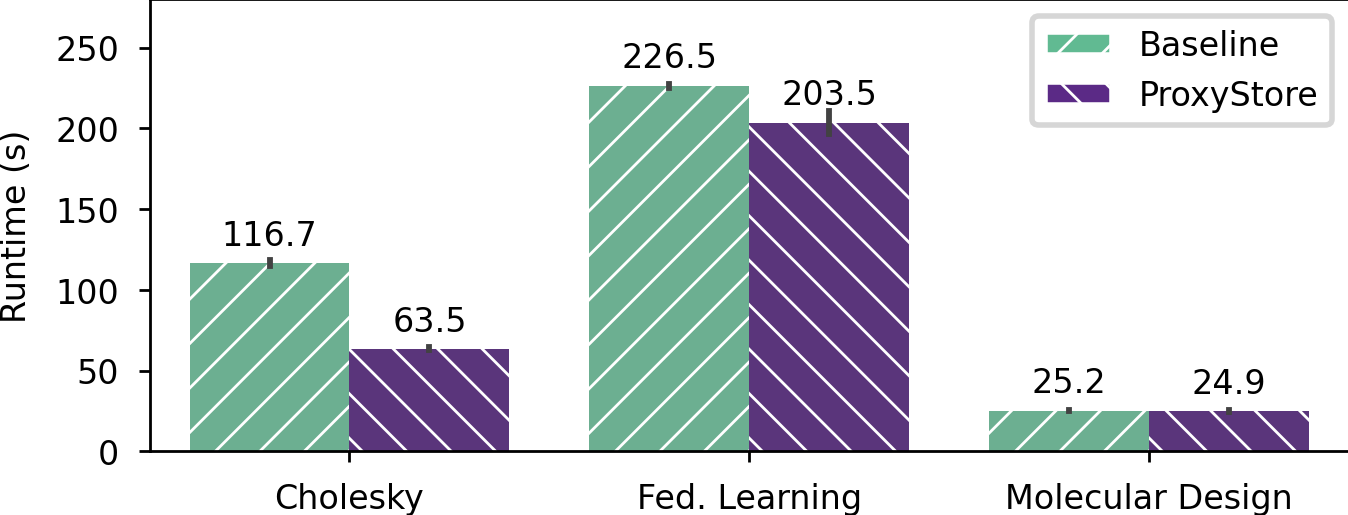

In [15]:
palette = {'Baseline': '#61BA92', 'ProxyStore': '#5B2A86'}
hatches = ['///', '\\\\\\']
hatchcolor = (1, 1, 1, 1)

fig, ax = plt.subplots()
handle = seaborn.barplot(
    data,
    x="app",
    y="runtime",
    hue="method",
    errorbar='sd',
    palette=palette,
    ax=ax,
)
for container, hatch in zip(ax.containers, hatches):
    for patch in container:
        patch.set_hatch(hatch)
        patch._hatch_color = hatchcolor
    handle.bar_label(container, size=6, padding=2, fmt='{:.1f}')
handle.set(xlabel=None, ylabel='Runtime (s)', ylim=(0, 280))
handle.get_legend().set_title(None)

_, labels = ax.get_legend_handles_labels()
handles = [
    matplotlib.patches.Patch(facecolor=color, hatch=hatch, edgecolor=hatchcolor)
    for color, hatch in zip(palette.values(), hatches)
]
ax.legend(handles, labels)

fig.tight_layout(w_pad=3)
fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/app-makespan.pdf', pad_inches=0.05)